# Benchmark InfoGroup against other datasets

## Data coverage

### InfoGroup (IG)
- Years 1997-2015
  - States VI and PR 2003-2015
- Establishment level micro data
- Location, industry, employment, sales

### County Business Patterns (CBP)
[Homepage](https://www.census.gov/programs-surveys/cbp.html)
- Years 1986 - 2015
- Aggregated establishment, employment counts and payroll by:
  - year
  - establishment size
  - industry (SIC 1986-1997, NAICS 1998-2015)
  - legal form of organization:
    - US file: 2008-2015
    - state file: 2010-2015
  - state
  - metropolitan, micropolitan area
  - county
  - zip code
- Data suppression flags
- Noise flags (2007-2015)

### Business Dynamics Statistics (BDS)
[Homepage](https://www.census.gov/ces/dataproducts/bds/)
- Employment – job creation and destruction
- Job expansions and contractions
- Number of establishments
- Establishment openings and closings
- Number of startups and firm shutdowns
- Annual statistics for 1976–2014
  - Age and size of firms and establishments
  - State
  - Metro/Non-metro and MSA
  - Standard Industrial Classification sectors
- Coverage of the entire U.S. economy
  

## Conclusions
- IG minimal employment is 1, there are no 0-sized establishments.
- In 2015:
  - 31.6% of all establishments were of size 1-2 and had 5% of total employment
  - size 1-9: 77.7% of establishments, 24.6% of employment
  - size 100+: 1.4% establishments and 25.1% of employment
- Distribution of employment and establishments over size did not change much between 1997 and 2015
- In 1998-2002 employment looks underreported, especially in small establishments.
- IG has about 2 times as many establishments as CBP or BDS, and about 30% higher employment.
- Difference grows over time.
- Dynamics is similar, but there are years where IG shows dynamics not present in CBP/BDS: jump in 2001, drop in 2011 (especially employment).
- By size:
  - No group where IG < CBP or BDS
  - Largest difference in 1-4 and 5-9 groups
  - 100-249, 250-499 and 500-999 groups are very close
- By state
  - establishments IG/CBP ratio ranges from 1.3 to 2.8, IG/BDS from 1.5 to 3.2,
  - employment employment IG/CBP from 1.0 to 1.8, IG/BDS from 1.0 to 1.8,
  - some states are strong outliers (e.g. DC has much higher counts in IG)
- By industry
  - Strong outliers, especially in NAICS (11, 55, 61, 92)
  - For some, dynamics differs significantly from aggregate



# Initialization
Functions and other code snippets used in various parts on this notebook.

In [1]:
import os
import tempfile
import json
import requests
import urllib
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'
from IPython.display import display as disp
pd.options.display.max_columns = 25

## Save session

In [146]:
def save_session(filename='session.pkl'):
    '''Save current session.'''
    variables_to_save = [
        'cbp_by_size',
        'cbp_by_state',
        'cbp_by_naics',
        'bds_by_size',
        'bds_by_state',
        'bds_by_sic',
        'ig_by_size',
        'ig_by_state',
        'ig_by_naics',
        'ig_by_sic'
    ]
    
    store = {k: globals()[k] for k in variables_to_save}
    
    with open(filename, 'wb') as f:
        pickle.dump(store, f)
        
save_session()

In [3]:
def load_session(filename='session.pkl'):
    '''Restore previous session.'''
    with open(filename, 'rb') as f:
        store = pickle.load(f)
    
    for k, v in store.items():
        globals()[k] = v
        
load_session()

In [32]:
# temporary directory
tmpdir_autoremove = False

if tmpdir_autoremove:
    tmpdir = tempfile.TemporaryDirectory(dir='.')
    tmpdir = tmpdir.name
else:
    tmpdir = 'tmp/'
    try:
        os.mkdir(tmpdir)
    except FileExistsError:
        pass

In [5]:
census_bucket_name = 'ig-census'
project_id = 'info-group-162919'

# metadata
meta_filename = 'census.json'
with open(meta_filename, 'r') as f:
    meta = json.load(f)
    
ig_years = list(range(1997, 2016))
cbp_years = list(range(1986, 2016))

In [16]:
url = 'https://www2.census.gov/programs-surveys/cbp/datasets/1986/cbp86us.txt'
path = urllib.parse.urlparse(url).path
os.path.basename(path)

'cbp86us.txt'

In [24]:
def download_text(url, dir):
    '''
    Download plain text file and save it into directory. Return name of the downloaded file.
    '''
    from requests import get
    from os.path import join, basename
    from urllib.parse import urlparse
    
    file_name = basename(urlparse(url).path)
    r = get(url)
    file_path = join(dir, file_name)
    with open(file_path, 'w') as f:
        f.writelines(r.text)
    
    return file_name

In [6]:
def download_unzip(url, dir):
    '''
    Download zip file and extract content into given directory. Return list of extracted filenames.
    '''
    from requests import get
    from io import BytesIO
    from zipfile import ZipFile
    
    # download zip file
    r = get(url)
    r.raise_for_status()
    
    # unzip
    zf = ZipFile(BytesIO(r.content))
    zf.extractall(dir)
    
    return zf.namelist()

In [7]:
def gs_file_exists(bucket_name, object_name):
    from google.cloud import storage
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    blob = bucket.get_blob(object_name)
    return blob is not None

In [8]:
def gs_upload_compress(file_path, bucket_name, object_name=''):
    '''
    Compress and upload file to GCS bucket.
    Example: gs_upload_compress('raw_data/cbp08.txt', 'ig-anton', 'cbp/2008.txt')
    If object_name == '', object will be in bucket root and will have same name as uploaded file.
    '''

    # client library does not have an analog of -Z option of gsutil, so uploads will be done with shell commands
    from subprocess import Popen, PIPE
    
    # construct shell command
    gs_path = 'gs://' + bucket_name + '/' + object_name
    p = Popen(['gsutil', 'cp', '-Z', file_path, gs_path], stdout=PIPE, stderr=PIPE, encoding='UTF-8')
    
    # run shell command and save (stdout, stderr) to o
    o = p.communicate()
    
    # raise on error
    if p.returncode != 0:
        raise Exception('GSC upload error: {}'.format(o[1]))

In [9]:
def gs_download(bucket_name, object_name, file_path='./'):
    '''
    Download file from GCS if it does not exist locally yet. Gzipped files (Content-Encoding: gzip) are automatically uncompressed.
    If file_path ends with "/", it is considered a directory and object basename is used as file name.
    file_path can be just a basename (e.g. "cbp99st.txt"), then it will be saved to current directory.
    '''
    from google.cloud import storage
    from os.path import basename, join, exists
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    blob = bucket.get_blob(object_name)
    if basename(file_path) == '':
        file_path = join(file_path, basename(object_name))
    if not exists(file_path):
        blob.download_to_filename(file_path)

In [10]:
# codes
file_name = os.path.join(tmpdir, 'codes.json')

gs_download(census_bucket_name, 'codes/state.json', file_name)
with open(file_name) as f:
    state_codes = json.load(f)

gs_download(census_bucket_name, 'codes/naics.json', file_name)
with open(file_name) as f:
    naics_codes = json.load(f)
    
gs_download(census_bucket_name, 'codes/sic.json', file_name)
with open(file_name) as f:
    sic_codes = json.load(f)

In [11]:
def meta_find(keywords):
    '''
    Find and print records in GS Census data that include all keywords as substrings.
    :keywords: must be a list.
    Examples: meta_find(['1998']), meta_find(['estab', 'size', 'sector'])
    '''
    import json
    
    def record_has_keyword(record, keyword):
        'Check if values of :record: dicitonary contain :keyword:.'
        keyword = keyword.lower()
        for v in record.values():
            v = str(v)
            v = v.lower()
            if v.find(keyword) != -1:
                return True
        return False
    
    def record_has_keywords(record, keywords):
        for k in keywords:
            if not record_has_keyword(record, k):
                return False
        return True
    
    def process(record):
        if record_has_keywords(record, keywords):
            print(json.dumps(record, indent=2))
            
    for r in meta['cbp']['tables']:
        process(r)
        
    for r in meta['bds']['estab']:
        process(r)
        
    for r in meta['bds']['firm']:
        process(r)


# Metadata

Information about Census data files, their original download links and locations in GCS.

## CBP

For now, download state files all years (1986-2015), https://www2.census.gov/programs-surveys/cbp/datasets/{y}/cbp{y2}st.zip, and save each as cbp{y2}st.txt.

In [29]:
years = list(range(1986, 2016))
obj_name_prefix = 'cbp/'

cbp_meta = {
    'years': years,
    'us': [],
    'state': []
}

for y in years:
    y2 = str(y)[2:]

    # US file
    name = 'cbp{y2}us.txt'.format(y2=y2)
    if y < 2008:
        # plain text
        url = 'https://www2.census.gov/programs-surveys/cbp/datasets/{y}/cbp{y2}us.txt'.format(y=y, y2=y2)
    else:
        # zipped text
        url = 'https://www2.census.gov/programs-surveys/cbp/datasets/{y}/cbp{y2}us.zip'.format(y=y, y2=y2)
    t = {
        'name': name,
        'desc': 'Complete U.S. File, {y}'.format(y=y),
        'year': y,
        'obj_name': obj_name_prefix + name,
        'url': url
    }
    cbp_meta['us'].append(t)
    
    # state file
    name = 'cbp{y2}st.txt'.format(y2=y2)
    t = {
        'name': name,
        'desc': 'Complete State File, {y}'.format(y=y),
        'year': y,
        'obj_name': obj_name_prefix + name,
        'url': 'https://www2.census.gov/programs-surveys/cbp/datasets/{y}/cbp{y2}st.zip'.format(y=y, y2=y2)
    }
    cbp_meta['state'].append(t)

## BDS
Get list of available BDS files.

In [30]:
meta['cbp'] = cbp_meta

In [11]:
from requests import get
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import os

bds_meta = {
    'firm': [],
    'estab': []
}

index_pages = {
    'firm': 'https://www.census.gov/ces/dataproducts/bds/data_firm.html',
    'estab': 'https://www.census.gov/ces/dataproducts/bds/data_estab.html'
}

obj_name_prefix = 'bds/'

for k, v in index_pages.items():
    r = get(v)
    page = BeautifulSoup(r.text, 'lxml')
    trs = page.find(class_='datatable').find_all('tr')
    for tr in trs[1:]:
        tds = tr.find_all('td')
        desc = tds[0].text
        if desc != '':
            href = tds[2].a.get('href')
            url_path = urlparse(href).path
            file_name = os.path.basename(url_path).replace('_release', '')
            x = {
                'desc': desc,
                'url': href,
                'name': file_name,
                'obj_name': obj_name_prefix + file_name
            }
            bds_meta[k].append(x)

## Save

In [ ]:
import json

meta = {
    'desc': 'This file contains information about Census data, available in Google Cloud Storage.',
    'gs_bucket': 'ig-census',
    'cbp': cbp_meta,
    'bds': bds_meta
}

In [31]:
with open('census.json', 'w') as f:
    json.dump(meta, f, indent=2)

# Explore IG

Descriptive statistics of IG data.

## By size

In [39]:
# by year and size (employment category)

table = 'original.data'

# there are only 3 establishments in 1997 that reported employees = 0, so I ignore them and label as null

query = '''
select
  year,
  case
    when employees = 1 then 1
    when employees = 2 then 2
    when employees between 3 and 4 then 3
    when employees between 5 and 9 then 5
    when employees between 10 and 19 then 10
    when employees between 20 and 49 then 20
    when employees between 50 and 99 then 50
    when employees between 100 and 249 then 100
    when employees between 250 and 499 then 250
    when employees between 500 and 999 then 500
    when employees >= 1000 then 1000
    else -1
  end as size,
  count(*) as est,
  sum(employees) as emp
from
  `{table}`
group by
  year,
  size
order by
  year,
  size;
'''

query = query.format(table=table)

df = pd.read_gbq(query, project_id, dialect='standard', verbose=False)

df['size'] = df['size'].astype('category', categories=[-1, 1, 2, 3, 5, 10, 20, 50, 100, 250, 500, 1000], ordered=True)
df['size'].cat.categories = ['null', '1', '2', '3-4', '5-9', '10-19', '20-49', '50-99', '100-249', '250-499', '500-999', '1000+']

df = df.set_index(['size', 'year'])
df = df.unstack()
df = df.sort_index(1)
df = df.astype(float) # int with missing values
ig_by_size = df

### Distribution

In [34]:
def plot_distribution(y):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    def add_labels(ax, x):
        rects = ax.patches
        shares = x / x.sum()
        labels = ['%3.1f%%' % (x * 100) for x in shares]
        for rect, label in zip(rects, labels):
            ax.text(rect.get_x() + rect.get_width() + 2, rect.get_y() + rect.get_height() / 2, label, ha='left', va='center')


    ax1.set_title('Establishments, %d' % y)
    x = ig_by_size['est'].loc[:, y]
    x.plot('barh', ax=ax1)
    add_labels(ax1, x)

    ax2.set_title('Employment, %d' % y)
    x = ig_by_size['emp'].loc[:, y]
    x.plot('barh', ax=ax2)
    add_labels(ax2, x)

    plt.show()

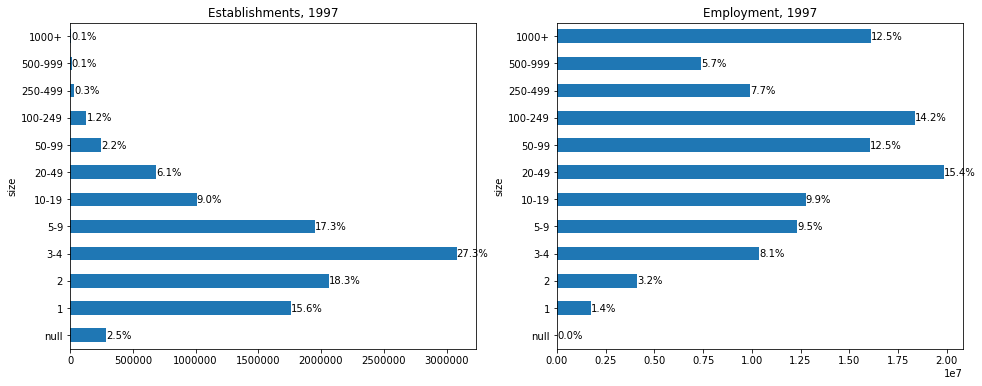

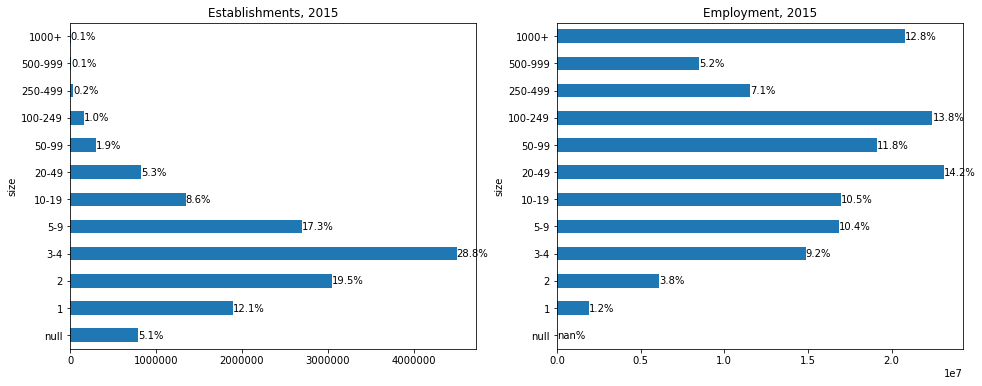

In [41]:
plot_distribution(1997)
plot_distribution(2015)

### Evolution over time

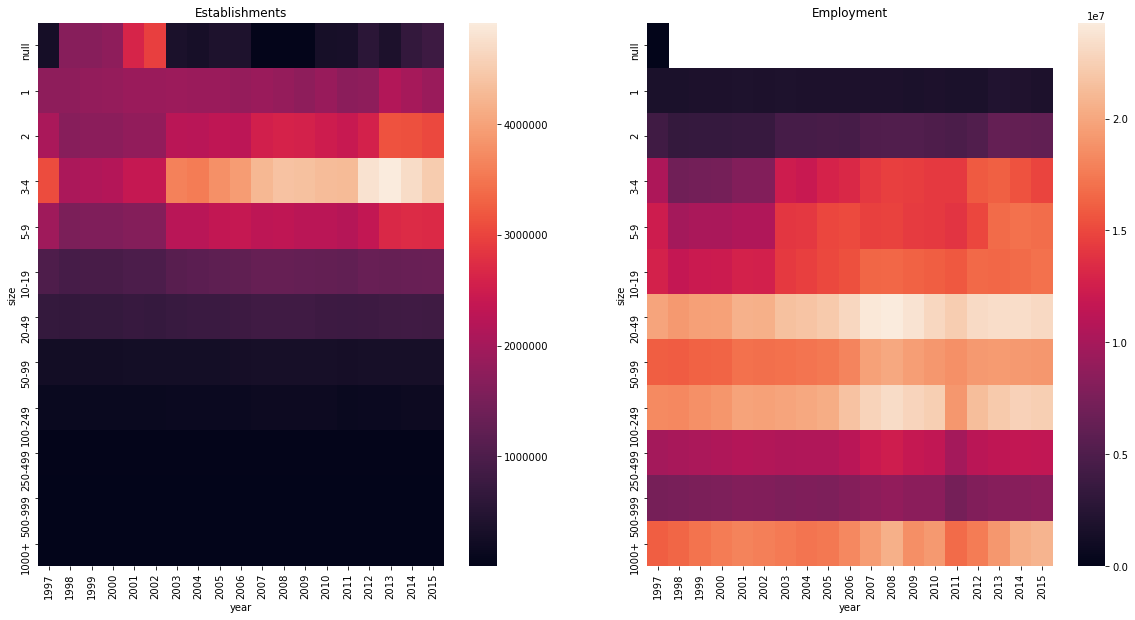

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Establishments')
sns.heatmap(ig_by_size['est'], ax=ax1)
ax2.set_title('Employment')
sns.heatmap(ig_by_size['emp'], ax=ax2)
plt.show()

# Prepare data for comparison

## Get CBP and BDS to local disk

In [33]:
# download all years of CBP from GCS to disk
for geo in ['us', 'state']:
    for t in meta['cbp'][geo]:
        file_name = os.path.join(tmpdir, t['name'])
        gs_download(census_bucket_name, t['obj_name'], file_name)
    

# download BDS files
names = ['bds_e_st.csv', 'bds_e_sic.csv', 'bds_e_sz.csv']
for t in meta['bds']['estab']:
    name = t['name']
    if name not in names: continue
    file_name = os.path.join(tmpdir, name)
    gs_download(census_bucket_name, t['obj_name'], file_name)

## Read CBP into pandas

- Only need IG years (1997-2015)
  - NAICS years for industry table (1998-2015)
- Only keep `lfo == '-'` (all forms):
  - by state and by NAICS: since 2010
  - US file (for size): since 2008
- Create three tables:
  - rows: size, columns: (est, emp), year
  - rows: state, columns: (est, emp), year
  - rows: 2-digit NAICS, columns: (est, emp), year
- For size table, keep `sic == '----'` (in 1997) or `naics == '------'` (1998-2015)
- Some 2-digit NAICS codes in CSV files are labelled by first number in range (e.g. "31" means "31-33" etc)
- "92" is labelled as "95", and it is only reported in 1998-2002

In [28]:
years = list(range(1997, 2016))

cbp_by_state = {}
cbp_by_naics = {}
for t in meta['cbp']['state']:
    y = t['year']
    if y not in years: continue

    file_name = os.path.join(tmpdir, t['name'])
    df = pd.read_csv(file_name, dtype='object')
    df.columns = df.columns.str.lower()
    if y >= 2010: df = df[df.lfo == '-']
    if y == 1997:
        df = df[['fipstate', 'sic', 'emp', 'est']]
        df.columns = ['state', 'sic', 'emp', 'est']
    else:
        df = df[['fipstate', 'naics', 'emp', 'est']]
        df.columns = ['state', 'naics', 'emp', 'est']

    df.emp = pd.to_numeric(df.emp)
    df.est = pd.to_numeric(df.est)
    
    if y == 1997: df1 = df.loc[df.sic == '----', ['state', 'emp', 'est']]
    else: df1 = df.loc[df.naics == '------', ['state', 'emp', 'est']]
    df1.state = df1.state.map(state_codes['numcode_to_strcode'])
    df1 = df1.set_index('state')
    cbp_by_state[y] = df1
    
    if y == 1997: continue
    df2 = df.loc[(df.naics.str[2:] == '----') & (df.naics != '------'), ['naics', 'emp', 'est']]
    df2.naics = df2.naics.str[:2]
    df2.naics = df2.naics.replace({'31': '31-33', '44': '44-45', '48': '48-49', '95': '92'})
    df2 = df2.groupby('naics').sum()
    cbp_by_naics[y] = df2

df = pd.concat(cbp_by_state, axis=1)
df = df.swaplevel(0, 1, axis=1)
df = df.sort_index(1)
cbp_by_state = df

df = pd.concat(cbp_by_naics, axis=1)
df = df.swaplevel(0, 1, axis=1)
df = df.sort_index(1)
cbp_by_naics = df

In [136]:
# By size
size_groups = ['1-4', '5-9', '10-19', '20-49', '50-99', '100-249', '250-499', '500-999', '1000+']
col_names = pd.MultiIndex.from_product([size_groups, ['emp', 'est']])

years = list(range(1997, 2016))
cbp_by_size = {}
for t in meta['cbp']['us']:
    y = t['year']
    if y not in years: continue
        
    file_name = os.path.join(tmpdir, t['name'])
    df = pd.read_csv(file_name, dtype='object')
    df.columns = df.columns.str.lower()
    
    if y >= 2008: df = df[df.lfo == '-']
    if y == 1997: df = df[df.sic == '----']
    else: df = df[df.naics == '------']
    df = df[['e1_4', 'n1_4', 'e5_9', 'n5_9', 'e10_19', 'n10_19', 'e20_49', 'n20_49', 'e50_99', 'n50_99', 'e100_249', 'n100_249', 'e250_499', 'n250_499', 'e500_999', 'n500_999', 'e1000', 'n1000']]
    df.columns = col_names
    df = df.swaplevel(0, 1, axis=1)
    df = df.stack()
    df.index = df.index.droplevel()
    
    cbp_by_size[y] = df

df = pd.concat(cbp_by_size, axis=1)
df = df.swaplevel(0, 1, axis=1)
df = df.sort_index(1)

size_index = pd.CategoricalIndex(df.index)
size_index = size_index.reorder_categories(size_groups, ordered=True)
df.index = size_index
df = df.sort_index()

df = df.astype(int)

cbp_by_size = df

## Read BDS into pandas

- Only need IG years (1997-2015)
- Create three tables:
  - rows: size, columns: (est, emp), year
  - rows: state, columns: (est, emp), year
  - rows: 2-digit SIC, columns: (est, emp), year

In [ ]:
# By state
file_name = os.path.join(tmpdir, 'bds_e_st.csv')
df = pd.read_csv(file_name, dtype='object')
df = df[['year2', 'state', 'estabs', 'emp']]
df.columns = ['year', 'state', 'est', 'emp']

df.year = pd.to_numeric(df.year, downcast='integer')
df.state = df.state.map(state_codes['numcode_to_strcode'])
df.est = pd.to_numeric(df.est)
df.emp = pd.to_numeric(df.emp)

df = df[df.year >= 1997]
df = df.set_index(['state', 'year'])
df = df.unstack('year')
df = df.sort_index(1)
bds_by_state = df

# By SIC
file_name = os.path.join(tmpdir, 'bds_e_sic.csv')
df = pd.read_csv(file_name, dtype='object')
df = df[['year2', 'sic1', 'estabs', 'emp']]
df.columns = ['year', 'sic', 'est', 'emp']

df.year = pd.to_numeric(df.year, downcast='integer')
df.est = pd.to_numeric(df.est)
df.emp = pd.to_numeric(df.emp)

df = df[df.year >= 1997]
df = df.set_index(['sic', 'year'])
df = df.unstack('year')
df = df.sort_index(1)
bds_by_sic = df

In [135]:
# By size
size_groups = ['1-4', '5-9', '10-19', '20-49', '50-99', '100-249', '250-499', '500-999', '1000+']

file_name = os.path.join(tmpdir, 'bds_e_sz.csv')
df = pd.read_csv(file_name, dtype='object')

df = df[['year2', 'size', 'Estabs', 'Emp']]
df.columns = ['year', 'size', 'est', 'emp']

rename = {
    'a) 1 to 4': '1-4',
    'b) 5 to 9': '5-9',
    'c) 10 to 19': '10-19',
    'd) 20 to 49': '20-49',
    'e) 50 to 99': '50-99',
    'f) 100 to 249': '100-249',
    'g) 250 to 499': '250-499',
    'h) 500 to 999': '500-999',
    'i) 1000+': '1000+'
}
df.loc[:, 'size'] = df['size'].map(rename)

df.year = pd.to_numeric(df.year, downcast='integer')
df.est = pd.to_numeric(df.est)
df.emp = pd.to_numeric(df.emp)

df = df[df.year >= 1997]

df = df.set_index(['size', 'year'])
df = df.unstack('year')
df = df.sort_index(1)

size_index = pd.CategoricalIndex(df.index)
size_index = size_index.reorder_categories(size_groups, ordered=True)
df.index = size_index
df = df.sort_index()

bds_by_size = df

## Query IG into pandas
- Exclude PR and VI: not all years, and not in CBP nor BDS.
- For NAICS drop 1997 (not in CBP)
- For SIC drop 2015 (not in BDS)

In [30]:
# by year and state
query = '''
SELECT
  year,
  state,
  COUNT(*) as est,
  SUM(employees) as emp
FROM
  `original.data`
WHERE
  state != 'PR' and state != 'VI'
GROUP BY
  year, state;
'''

df = pd.read_gbq(query, project_id, dialect='standard', verbose=False)

df = df.set_index(['state', 'year'])
df = df.unstack()
df = df.astype(int)
df = df.sort_index(1)
ig_by_state = df

In [31]:
# by year and naics
query = '''
SELECT
  substr(naics, 1, 2) as naics,
  year,
  COUNT(*) as est,
  SUM(employees) as emp
FROM
  `original.data`
WHERE
  state != 'PR' and state != 'VI' and year > 1997
GROUP BY
  year, naics;
'''

df = pd.read_gbq(query, project_id, dialect='standard', verbose=False)

# naics = "99" is "unknown industry"
df = df.fillna({'naics': '99', 'emp': 0})
df.naics = df.naics.replace({'31': '31-33', '32': '31-33', '33': '31-33', 
                             '44': '44-45', '45': '44-45', 
                             '48': '48-49', '49': '48-49'})
df = df.groupby(['naics', 'year']).sum()
df = df.unstack('year')
df = df.sort_index(1)
ig_by_naics = df

In [32]:
query = '''
SELECT
  substr(sic, 1, 2) as sic,
  year,
  COUNT(*) as est,
  SUM(employees) as emp
FROM
  `original.data`
WHERE
  state != 'PR' and state != 'VI' and year <= 2014
GROUP BY
  year, sic
ORDER BY
  year, sic;
'''
df = pd.read_gbq(query, project_id, dialect='standard', verbose=False)


# group sic codes into bins that are BDS industry SIC codes
df = df[df.sic.notnull()]
df.sic = df.sic.astype(int)
df = df[df.sic.between(7, 89)] # only these are in BDS

sic_int_bins = [int(x) for x in bds_by_sic.index ]
sic_int_bins.sort()
sic_bin_labels = ['%02d' % x for x in sic_int_bins]
sic_int_bins += [90]

df.sic = pd.cut(df.sic, sic_int_bins, right=False, labels=sic_bin_labels).astype('object')

df = df.pivot_table(['est', 'emp'], 'sic', columns='year', aggfunc='sum')
df = df.sort_index(1)
df = df.astype(int)

ig_by_sic = df

# Compare

## By year 

In [23]:
ig_by_year = ig_by_state.sum()
cbp_by_year = cbp_by_state.sum()
bds_by_year = bds_by_state.sum()

In [27]:
cmp_by_year = {}
for v in ['est', 'emp']:
    cmp_by_year[v] = pd.DataFrame({
        'ig': ig_by_year[v],
        'cbp': cbp_by_year[v],
        'bds': bds_by_year[v]})

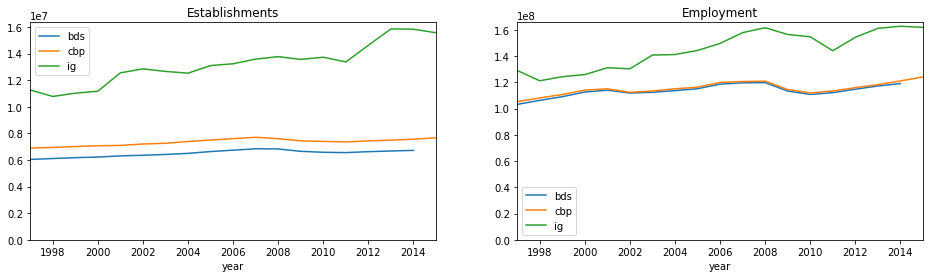

In [43]:
# absolute values
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(121)
cmp_by_year['est'].plot(ax=ax)
ax.set_ylim(bottom=0)
ax.set_title('Establishments')
ax = fig.add_subplot(122)
cmp_by_year['emp'].plot(ax=ax)
ax.set_ylim(bottom=0)
ax.set_title('Employment')
plt.show()

In [61]:
# ratio
basis = 'bds'
df = cmp_by_year['est']
disp(df.apply(lambda x: x / df[basis], axis=0).T)
df = cmp_by_year['emp']
disp(df.apply(lambda x: x / df[basis], axis=0).T)

year,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
bds,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN
cbp,1.141244,1.136462,1.135219,1.136914,1.124749,1.133533,1.130901,1.137026,1.130642,1.128377,1.126000,1.113305,1.117602,1.124426,1.122085,1.121767,1.121959,1.125238,NaN
ig,1.864413,1.763872,1.785016,1.796098,1.989332,2.022659,1.972807,1.927532,1.974274,1.964026,1.984903,2.016264,2.038373,2.086305,2.039552,2.206838,2.375169,2.354762,NaN


year,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
bds,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN
cbp,1.020492,1.017376,1.015073,1.012972,1.009252,1.005156,1.008798,1.012025,1.010222,1.010981,1.008169,1.009375,1.010374,1.010628,1.011634,1.010264,1.009146,1.016516,NaN
ig,1.250469,1.140359,1.139408,1.118038,1.150262,1.165181,1.252478,1.241513,1.253444,1.261580,1.319716,1.349308,1.380425,1.396416,1.284807,1.344935,1.374984,1.366253,NaN


## By year and size

In [84]:
df = ig_by_size
df = df.reset_index()

new_size = df['size'].copy()
new_size[(new_size == '2') | (new_size == '3-4')] = '1'
new_size = new_size.cat.remove_unused_categories()
new_size.cat.categories = ['null', '1-4', '5-9', '10-19', '20-49', '50-99', '100-249', '250-499', '500-999', '1000+']

df = df.groupby(new_size).sum()

df = df.reindex(columns = ig_by_size.columns)

ig_by_size_cmp = df

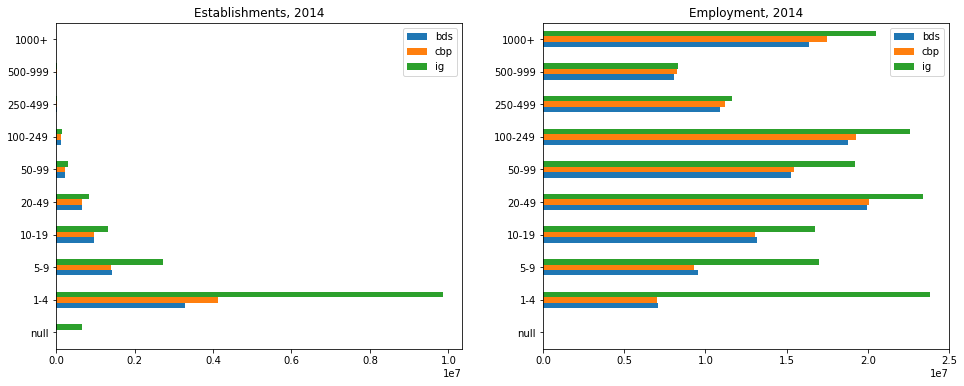

In [143]:
y = 2014
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title('Establishments, %d' % y)
df = pd.DataFrame({'cbp': cbp_by_size['est'].loc[:, y], 
                   'bds': bds_by_size['est'].loc[:, y], 
                   'ig': ig_by_size_cmp['est'].loc[:, y]})
df = df.loc[ig_by_size_cmp.index, :]
df.plot.barh(ax=ax1)

ax2.set_title('Employment, %d' % y)
df = pd.DataFrame({'cbp': cbp_by_size['emp'].loc[:, y],
                   'bds': bds_by_size['emp'].loc[:, y], 
                   'ig': ig_by_size_cmp['emp'].loc[:, y]})
df = df.loc[ig_by_size_cmp.index, :]
df.plot.barh(ax=ax2)

plt.show()

In [147]:
# ratio
basis = bds_by_size

disp(ig_by_size_cmp['est'] / basis['est'])
disp(ig_by_size_cmp['emp'] / basis['emp'])

year,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
null,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-4,2.333914,1.863550,1.901248,1.922065,2.014718,1.999536,2.520717,2.446182,2.471200,2.451640,2.614743,2.672887,2.723247,2.707559,2.627668,2.805626,3.123521,2.990912,NaN
5-9,1.428033,1.131164,1.150063,1.151691,1.186767,1.168210,1.588164,1.576582,1.637612,1.629665,1.544430,1.556362,1.552032,1.569756,1.554937,1.655438,1.880678,1.909048,NaN
10-19,1.200523,1.062570,1.075662,1.063606,1.092939,1.083141,1.239641,1.250580,1.276963,1.287135,1.330007,1.336917,1.336209,1.334766,1.324090,1.398887,1.373238,1.378850,NaN
20-49,1.259635,1.183445,1.177321,1.154662,1.181512,1.169929,1.207290,1.209628,1.222869,1.250691,1.291014,1.293550,1.301913,1.302442,1.274475,1.300018,1.303862,1.282362,NaN
50-99,1.362483,1.304208,1.288164,1.255223,1.270719,1.272634,1.272341,1.265721,1.267961,1.287447,1.374150,1.402426,1.400850,1.443429,1.419722,1.427292,1.409728,1.381018,NaN
100-249,1.228619,1.182489,1.174302,1.161983,1.183716,1.206555,1.218167,1.216659,1.214705,1.256642,1.303830,1.328002,1.341376,1.393706,1.187208,1.317410,1.329466,1.327653,NaN
250-499,1.152230,1.121686,1.100114,1.081458,1.096027,1.128824,1.121498,1.109165,1.094607,1.127626,1.200437,1.225744,1.220031,1.264650,1.076239,1.173676,1.159976,1.151159,NaN
500-999,1.149550,1.106175,1.095799,1.074408,1.078866,1.116634,1.130774,1.125389,1.091723,1.127825,1.163816,1.209581,1.202216,1.260687,1.103481,1.153174,1.148015,1.142673,NaN
1000+,1.265008,1.232371,1.214172,1.195197,1.184929,1.202845,1.186619,1.165231,1.159683,1.204079,1.256463,1.301956,1.265078,1.322540,1.128673,1.209320,1.225391,1.265199,NaN


year,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
null,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-4,2.384753,1.797531,1.838683,1.851010,1.980587,1.942856,2.679256,2.590027,2.686218,2.685853,2.875578,3.015295,3.124213,3.061693,2.986714,3.205875,3.492571,3.361649,NaN
5-9,1.332300,1.073840,1.093645,1.088849,1.131371,1.111942,1.494842,1.480743,1.541577,1.511521,1.457583,1.485324,1.514402,1.508264,1.490229,1.569152,1.760049,1.784819,NaN
10-19,1.095502,0.985279,0.999238,0.983088,1.020276,1.012108,1.131475,1.141586,1.167465,1.157759,1.227635,1.243749,1.270343,1.256797,1.228452,1.280065,1.266094,1.269792,NaN
20-49,1.158999,1.087695,1.082749,1.059169,1.093467,1.089757,1.122996,1.126319,1.139696,1.153571,1.199297,1.206364,1.247363,1.237339,1.185636,1.208511,1.190712,1.171556,NaN
50-99,1.226648,1.179337,1.166436,1.133017,1.163367,1.177843,1.162929,1.158931,1.160180,1.164051,1.266369,1.291375,1.330754,1.348431,1.309716,1.307121,1.283760,1.256574,NaN
100-249,1.117429,1.072214,1.071071,1.051240,1.088190,1.119742,1.113102,1.112582,1.106005,1.138839,1.193004,1.211462,1.274740,1.292944,1.086245,1.195654,1.206405,1.202143,NaN
250-499,1.065536,1.034090,1.019215,0.991407,1.021839,1.065215,1.038360,1.023301,1.012145,1.036077,1.109580,1.136119,1.161797,1.193047,0.987335,1.080098,1.074993,1.067319,NaN
500-999,1.057473,1.020692,1.014545,0.991138,0.995130,1.047712,1.043830,1.030882,1.004783,1.025726,1.058499,1.105378,1.122376,1.160918,0.995293,1.036760,1.030780,1.030152,NaN
1000+,1.285331,1.254714,1.238809,1.212932,1.199723,1.230303,1.233951,1.209908,1.208247,1.219650,1.260121,1.313340,1.252314,1.321200,1.121421,1.140955,1.197553,1.249507,NaN


## By year and state

### CBP

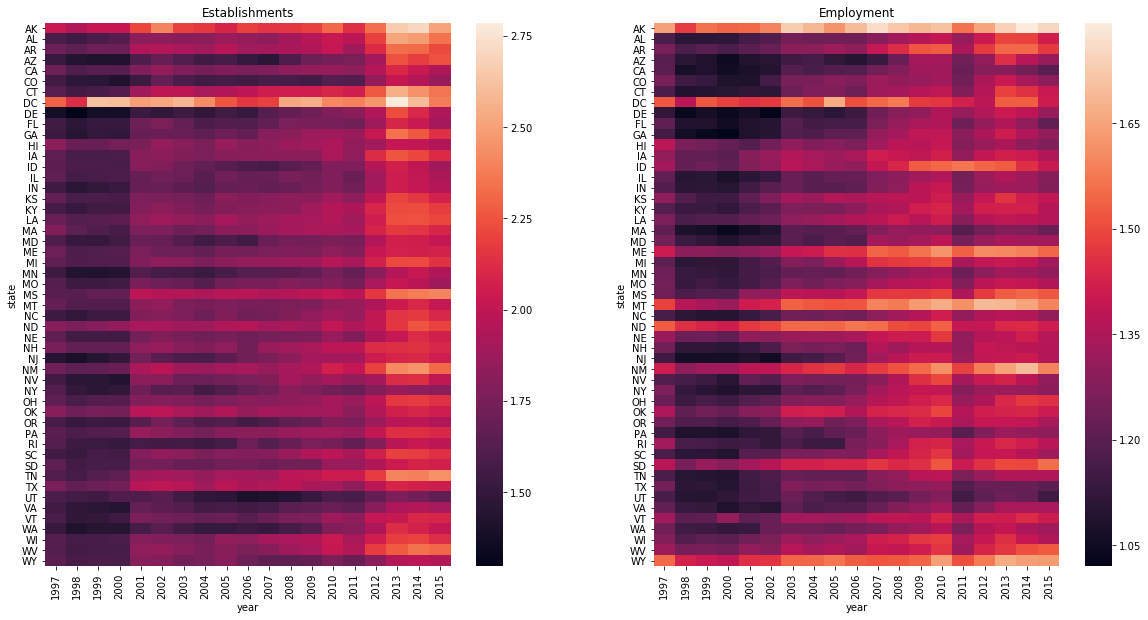

In [88]:
ratio = ig_by_state / cbp_by_state

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Establishments')
sns.heatmap(ratio['est'], ax=ax1)
ax2.set_title('Employment')
sns.heatmap(ratio['emp'], ax=ax2)
plt.show()

### BDS

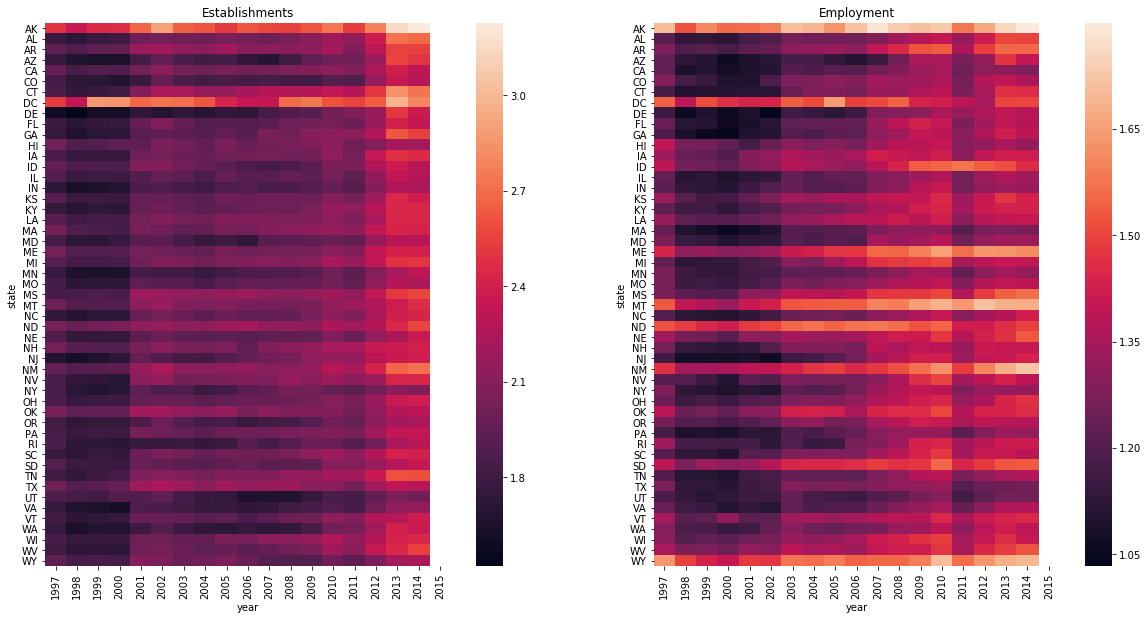

In [94]:
ratio = ig_by_state / bds_by_state

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Establishments')
sns.heatmap(ratio['est'], ax=ax1)
ax2.set_title('Employment')
sns.heatmap(ratio['emp'], ax=ax2)
plt.show()

## By year and industry

### CBP (NAICS)

In [109]:
ratio = ig_by_naics / cbp_by_naics
pd.DataFrame({
    'est': ratio['est'].mean(axis=1), 
    'emp':ratio['emp'].mean(axis=1)}).T

naics,11,21,22,23,31-33,42,44-45,48-49,51,52,53,54,55,56,61,62,71,72,81,92,99
emp,3.742429,0.670047,1.021540,1.147241,1.036353,1.372024,1.231030,0.931304,1.026533,1.025101,1.850277,1.228332,0.088334,0.440425,3.656431,1.251055,1.338326,1.087187,1.592530,7.272258,129.813937
est,3.591736,0.866913,1.306937,1.356224,1.432850,1.388154,1.700334,1.315253,1.717941,1.560126,1.768957,1.757985,0.163369,1.303473,3.468358,2.413330,1.732053,1.244830,2.213398,26.546449,17.810047


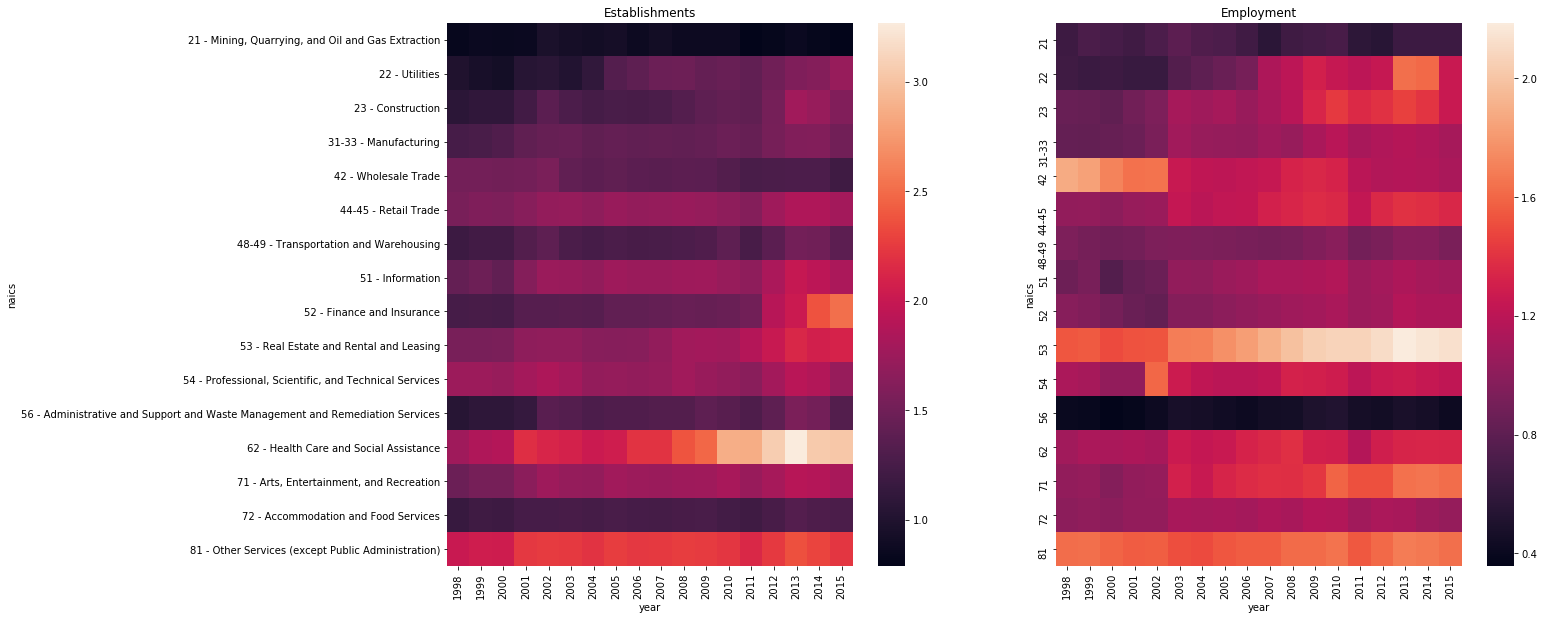

Excluded NAICS industries:
11 Agriculture, Forestry, Fishing and Hunting
55 Management of Companies and Enterprises
61 Educational Services
92 Public Administration
99 Unknown industry


In [129]:
# don't show strong outliers
exclude_naics = ['11', '55', '61', '92', '99']
index_mask = [x not in exclude_naics for x in ratio.index]
naics_labels = ['%s - %s' % (x, naics_codes[x]) for x in ratio.index if x not in exclude_naics]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Establishments')
df = ratio['est'][index_mask]
sns.heatmap(df, ax=ax1, yticklabels=naics_labels)
ax2.set_title('Employment')
df = ratio['emp'][index_mask]
sns.heatmap(df, ax=ax2)
plt.show()

print('Excluded NAICS industries:')
for x in exclude_naics:
    print(x, naics_codes[x])

### BDS (SIC)

In [130]:
ratio = ig_by_sic / bds_by_sic
pd.DataFrame({
    'est': ratio['est'].mean(axis=1), 
    'emp':ratio['emp'].mean(axis=1)}).T

sic,07,10,15,20,40,50,52,60,70
emp,1.278969,0.939606,1.207699,0.965157,0.986887,1.258725,1.176457,1.207724,1.295634
est,1.964756,1.314871,1.814807,1.408337,1.603585,1.393306,1.748849,1.716463,2.262233


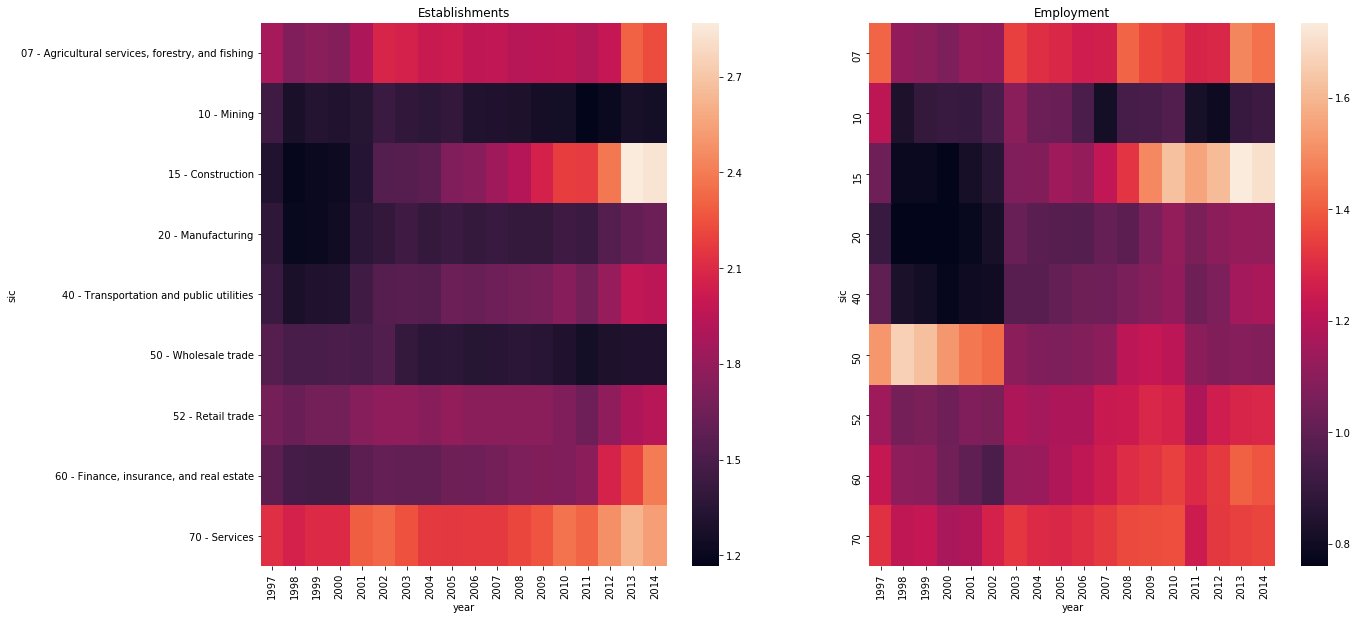

In [131]:
sic_labels = ['%s - %s' % (x, sic_codes[x]) for x in ratio.index]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Establishments')
df = ratio['est']
sns.heatmap(df, ax=ax1, yticklabels=sic_labels)
ax2.set_title('Employment')
df = ratio['emp']
sns.heatmap(df, ax=ax2)
plt.show()

# Appendix

Code used at intermediate steps.

## Code lookup tables

### State
2-digit, 2-letter and name

In [15]:
df = pd.read_csv('https://www2.census.gov/geo/docs/reference/state.txt', delimiter='|', dtype='object')

state_codes = {
    'numcode_to_strcode': dict(zip(df.STATE, df.STUSAB)),
    'numcode_to_name': dict(zip(df.STATE, df.STATE_NAME)),
    'strcode_to_name': dict(zip(df.STUSAB, df.STATE_NAME))
}

### NAICS

Code tables are updated every 5 years, but there is not much change at 2-digit level.

In [75]:
url = {
    1997: 'https://www.census.gov/eos/www/naics/reference_files_tools/1997/1997.html',
    2002: 'https://www.census.gov/cgi-bin/sssd/naics/naicsrch?chart=2002',
    2007: 'https://www.census.gov/cgi-bin/sssd/naics/naicsrch?chart=2007',
    2012: 'https://www.census.gov/cgi-bin/sssd/naics/naicsrch?chart=2012',
    2017: 'https://www.census.gov/cgi-bin/sssd/naics/naicsrch?chart=2017'
}

dfs = {}
for y, u in url.items():
    dfs[y] = pd.read_html(u)[0]

# what changed over years?
years = list(dfs.keys())
for y0, y1 in zip(years[:-1], years[1:]):
    print(y0, y1)
    print((dfs[y0] == dfs[y1]).sum())

# the only difference was "Mining" changed to "Mining, Quarrying, and Oil and Gas Extraction" between 2002 and 2007.
pd.concat([dfs[2002], dfs[2007]], axis=1)

1997 2002
0    21
1    21
dtype: int64
2002 2007
0    21
1    20
dtype: int64
2007 2012
0    21
1    21
dtype: int64
2012 2017
0    21
1    21
dtype: int64


,0,1,0,1
0,Sector,Description,Sector,Description
1,11,"Agriculture, Forestry, Fishing and Hunting",11,"Agriculture, Forestry, Fishing and Hunting"
2,21,Mining,21,"Mining, Quarrying, and Oil and Gas Extraction"
3,22,Utilities,22,Utilities
4,23,Construction,23,Construction
5,31-33,Manufacturing,31-33,Manufacturing
6,42,Wholesale Trade,42,Wholesale Trade
7,44-45,Retail Trade,44-45,Retail Trade
8,48-49,Transportation and Warehousing,48-49,Transportation and Warehousing
9,51,Information,51,Information


In [109]:
# create code map using 2012 table
y = 2012
codes = naics[y].iloc[1:, 0]
desc = naics[y].iloc[1:, 1]
naics_codes = dict(zip(codes, desc))
naics_codes['99'] = 'Unknown industry'

### SIC

In [78]:
# 2-digit SIC codes
url = 'https://www2.census.gov/programs-surveys/cbp/technical-documentation/records-layouts/sic-code-descriptions/sic88_97.txt'
r = requests.get(url)
r.raise_for_status()
sic_codes = {}
for line in r.text.split('\n'):
    code = line[:4]
    # ignore 4-digit codes and total (----)
    if code[2:] != '--' or code == '----':
        continue
    code = code[:2]
    desc = line[6:].capitalize()
    sic_codes[code] = desc

### Upload to GCS

In [111]:
with tempfile.TemporaryDirectory() as d:
    file_name = os.path.join(d, 'codes.json')
    
    with open(file_name, 'w') as f:
        json.dump(state_codes, f, indent=2)
    gs_upload_compress(file_name, census_bucket_name, 'codes/state.json')

    with open(file_name, 'w') as f:
        json.dump(naics_codes, f, indent=2)
    gs_upload_compress(f.name, census_bucket_name, 'codes/naics.json')
    
    with open(file_name, 'w') as f:
        json.dump(sic_codes, f, indent=2)
    gs_upload_compress(f.name, census_bucket_name, 'codes/sic.json')

## Download from Census

Download from Census website and save to GCS.

### CBP

In [ ]:
with tempfile.TemporaryDirectory(dir='.') as tmpdir:

    for geo in ['us', 'state']:
        for t in meta['cbp'][geo]:
            print('{} started...'.format(t['name']), end=' ')

            # check if file is already in GCS
            object_name = t['obj_name']
            if gs_file_exists(census_bucket_name, object_name):
                print('finished, file already exists.')
                continue

            # download file from Census
            url = t['url']
            file_extension = url[-3:]
            if file_extension == 'zip':
                downloaded_name = download_unzip(url, tmpdir)[0]
            else: # file_extension == 'txt'
                downloaded_name = download_text(url, tmpdir)

            # upload file to GCS
            file_path = os.path.join(tmpdir, downloaded_name)
            gs_upload_compress(file_path, census_bucket_name, object_name)

            print('finished.')

### BDS

In [ ]:
with tempfile.TemporaryDirectory(dir='.') as tmpdir:

    for k in ['firm', 'estab']:
        for t in meta['bds'][k]:
            print('{} started...'.format(t['name']), end=' ')

            # check if file is already in GCS
            object_name = t['obj_name']
            if gs_file_exists(census_bucket_name, object_name):
                print('finished, file already exists.')
                continue

            # download file from Census
            downloaded_name = download_text(t['url'], tmpdir)

            # upload file to GCS
            file_path = os.path.join(tmpdir, downloaded_name)
            gs_upload_compress(file_path, census_bucket_name, object_name)

            print('finished.')

## Explore CBP
Check how fields changed over time.

### US file

In [ ]:
# Read column lists for all years
raw_cols = {}
cols = {}
all_cols = []
years = []
for t in meta['cbp']['us']:
    y = t['year']
    years.append(y)
    file_name = os.path.join(tmpdir, t['name'])
    df = pd.read_csv(file_name, nrows=1)
    raw_cols[y] = list(df.columns)
    cols[y] = list(df.columns.str.lower())
    for c in cols[y]:
        if c not in all_cols:
            all_cols.append(c)

# Create table where columns that existed in year are marked with 1s, otherwise 0
col_by_year = pd.DataFrame(0, index=all_cols, columns=years)
for y in years:
    col_by_year.loc[cols[y], y] = 1

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
col_by_year.T.style.highlight_max(color='lightgrey')

### State file

In [ ]:
# Read column lists for all years
raw_cols = {}
cols = {}
all_cols = []
years = []
for t in meta['cbp']['state']:
    y = t['year']
    years.append(y)
    file_name = os.path.join(tmpdir, t['name'])
    df = pd.read_csv(file_name, nrows=1)
    raw_cols[y] = list(df.columns)
    cols[y] = list(df.columns.str.lower())
    for c in cols[y]:
        if c not in all_cols:
            all_cols.append(c)

# Create table where columns that existed in year are marked with 1s, otherwise 0
col_by_year = pd.DataFrame(0, index=all_cols, columns=years)
for y in years:
    col_by_year.loc[cols[y], y] = 1

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
col_by_year.T.style.highlight_max(color='lightgrey')